In [2]:
# Imports

import math, pickle, os, copy, sys, scipy.io, json, datetime

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

from numpy import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from utils_pv import *
from samples.data_sim import PVDataset

#### FL
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from trainer import Trainer
from models import *
from metrics import mse

# Add the project directory to the path
PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

# Set the random seed
random_seed = 46
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)

# Set the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'mps'

In [3]:
# Generate data

NUM_CLIENTS=1

months_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

train_columns = ['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1']

hour_begin, hour_end = 8, 18

city_names = ['Lausanne']
env_dict = {'city_names':city_names,
            'num_clients': NUM_CLIENTS, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std': 0, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':1,
            'module_name': get_available_modules('sandia')[0:NUM_CLIENTS], #['Canadian_Solar_CS5P_220M___2009_'],
            'inverter_name': get_available_inverters('cec')[0:NUM_CLIENTS], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
            'lags':[1], 'months':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'hours':np.arange(hour_begin, hour_end), 
            'train_scenarios':{'1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019}}}

env_dict = PVDataset(env_dict).generate_clients_data()

time_series = env_dict['train_scenarios']['1y']['time_series'][0]

# Remove nights
time_series = time_series[time_series['hour_day'].isin(np.arange(hour_begin, hour_end))]

# Add column day_of_month using column time
time_series['day'] = time_series['time'].dt.day

# Reorder columns
time_series = time_series[['time', 'year', 'month', 'day', 'hour_day', 'H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1', 'target']]
time_series.sample(3)

[INFO] generating data for Lausanne


,time,year,month,day,hour_day,H_sun,T2m,WS10m,hourofd_x,hourofd_y,dayofy_x,dayofy_y,station_irrad_direct_prev,station_irrad_diffuse_prev,lag 1,target
80342,2014-03-02 15:10:00,2014,3,2,15,19.74,15.806133,1.322021,-7.071068e-01,-0.707107,0.867456,0.497513,0.000000,83.888610,11.813488,24.716404
47821,2010-06-16 14:10:00,2010,6,16,14,51.01,12.308159,0.666466,-5.000000e-01,-0.866025,0.263665,-0.964614,0.000000,78.590382,10.458863,13.134210
62459,2012-02-16 12:10:00,2012,2,16,12,30.92,5.132578,2.181787,1.224647e-16,-1.000000,0.723644,0.690173,2.890523,171.632869,26.479149,17.932810


In [9]:
N_HISTORICAL_SAMPLES = 300
N_FRESH_DAYS = 30

N_EPOCHS = 300

LR_GRID = {
    # 0.0: [1e-2, 3e-2, 6e-2],
    0.25: [1e-2, 3e-2, 6e-2],
    0.5: [1e-2, 3e-2, 6e-2],
    0.75: [1e-2, 3e-2, 6e-2],
    # 1.0: [1e-2, 3e-2, 6e-2],
}

WD_grid = [5e-4, 5e-3, 5e-2]

In [10]:
def run_experiment(memory_weight_, lr_, weight_decay_, current_year, current_month, current_day):
    ### Set the seeds
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(random_seed)
    
    ### Define training and testing datasets
    current_date = datetime.date(current_year, current_month, current_day)

    ## Training dataset - memory & stream
    # Memory: random samples from the prediction window of previous years
    memory = []
    for _, row in time_series[(time_series['time'] > pd.to_datetime(current_date + pd.DateOffset(days=1))) & (time_series['time'] <= pd.to_datetime(current_date) + pd.DateOffset(days=30))].groupby(['month', 'day'])['time'].count().reset_index().iterrows():
        memory.append(time_series[(time_series['month'] == row['month']) & (time_series['day'] == row['day']) & (time_series['year']<current_date.year)])
    memory = pd.concat(memory)
    memory = memory.sample(N_HISTORICAL_SAMPLES, random_state=random_seed)

    x_memory = memory[train_columns].values
    y_memory = memory['target'].values.reshape(-1, 1)
    
    x_mean, x_std = x_memory.mean(axis=0), x_memory.std(axis=0)
    y_mean, y_std = y_memory.mean(axis=0), y_memory.std(axis=0)
    
    x_memory = (x_memory - x_mean) / x_std
    y_memory = (y_memory - y_mean) / y_std

    memory_dataset = torch.utils.data.TensorDataset(torch.tensor(x_memory), torch.tensor(y_memory))
    memory_dataloader = DataLoader(memory_dataset, batch_size=N_HISTORICAL_SAMPLES, shuffle=True)
    memory_iterator = iter(memory_dataloader)

    # Stream: Last N_FRESH_DAYS days
    start_date = pd.to_datetime(current_date - pd.DateOffset(days=N_FRESH_DAYS))
    end_date = pd.to_datetime(current_date)
    stream = time_series[(time_series['time'] > start_date) & (time_series['time'] < end_date)]

    x_stream = stream[train_columns].values
    y_stream = stream['target'].values.reshape(-1, 1)

    x_stream = (x_stream - x_mean) / x_std
    y_stream = (y_stream - y_mean) / y_std

    stream_dataset = torch.utils.data.TensorDataset(torch.tensor(x_stream), torch.tensor(y_stream))
    stream_dataloader = DataLoader(stream_dataset, batch_size=N_FRESH_DAYS*(hour_end-hour_begin), shuffle=True)
    stream_iterator = iter(stream_dataloader)

    ## Testing dataset - next 30 days
    test = time_series[(time_series['time'] > pd.to_datetime(current_date + pd.DateOffset(days=1))) & (time_series['time'] <= pd.to_datetime(current_date) + pd.DateOffset(days=30))]
                    
    x_test = test[train_columns].values
    y_test = test['target'].values.reshape(-1, 1)
    
    x_test = (x_test - x_mean) / x_std
    y_test = (y_test - y_mean) / y_std
    
    # Define model, optimizer, and trainer
    # model = SimpleNN(input_dim=len(train_columns), output_dim=1, hidden_dim=5).to(DEVICE)
    model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1=32, hidden_dim2=32).to(DEVICE)

    optimizer = optim.SGD(
        [param for param in model.parameters() if param.requires_grad],
        lr=lr_,
        momentum=0.9,
        weight_decay=weight_decay_,
    )

    trainer = Trainer(
        model=model,
        criterion=nn.MSELoss(reduction='none').to(DEVICE),
        metric=mse,
        device=DEVICE,
        optimizer=optimizer,
        cast_label=False,
    )
    
    # Train the model
    training_loss_history = []
    for epoch in range(N_EPOCHS):
        
        # Clear gradients
        trainer.optimizer.zero_grad()

        # Stream Loss
        if memory_weight_ != 1:
            try:
                x_stream, y_stream = next(stream_iterator)
            except StopIteration:
                stream_iterator = iter(stream_dataloader)
                x_stream, y_stream = next(stream_iterator)
                
            x_stream = x_stream.type(torch.float32).to(DEVICE)
            y_stream = y_stream.type(torch.float32).to(DEVICE)

            outs_stream = trainer.model(x_stream)
            loss_stream = trainer.criterion(outs_stream, y_stream).mean()

        else:
            loss_stream = 0

        # Memory Loss
        if memory_weight_ != 0:
            try:
                x_memory, y_memory = next(memory_iterator)
            except StopIteration:
                memory_iterator = iter(memory_dataloader)
                x_memory, y_memory = next(memory_iterator)

            x_memory = x_memory.type(torch.float32).to(DEVICE)
            y_memory = y_memory.type(torch.float32).to(DEVICE)

            outs_memory = trainer.model(x_memory)
            loss_memory = trainer.criterion(outs_memory, y_memory).mean()
        else:
            loss_memory = 0

        # Global Loss
        loss = memory_weight_ * loss_memory + (1 - memory_weight_) * loss_stream
        training_loss_history.append(loss.item())

        loss.backward()
        trainer.optimizer.step()

    # Test the model
    y_pred = trainer.model(torch.tensor(x_test).type(torch.float32).to(DEVICE)).detach().cpu().numpy()
    test_loss = trainer.criterion(torch.tensor(y_pred).type(torch.float32).to(DEVICE), torch.tensor(y_test).type(torch.float32).to(DEVICE)).mean().item()
        
    return training_loss_history, y_test*y_std + y_mean, y_pred*y_std + y_mean, test_loss

In [ ]:
# define results dict
results = {'memory_weight': {}, 'lr': {}, 'weight_decay': {}, 'current_year': {}, 'current_month': {}, 'current_day': {}, 'training_loss_history': {}, 'y_test': {}, 'y_pred': {}, 'test_loss': {}}

num_config = len(LR_GRID.keys()) * len(WD_grid) * len(LR_GRID[0.25])

with tqdm(total=num_config) as pbar:

    for memory_weight in LR_GRID.keys():
        for lr in LR_GRID[memory_weight]:
            for weight_decay in WD_grid:
            
                # print(f'\nMemory_weight={memory_weight} | lr={lr} | weight_decay={weight_decay}')
                
                for year in [2014, 2015, 2016, 2017, 2018]:
                    for month in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
                        current_date = datetime.date(year, month, 1)
                        current_year, current_month, current_day = current_date.year, current_date.month, current_date.day
                    
                        # run experiment for current values
                        training_loss_history, y_test, y_pred, test_loss = run_experiment(memory_weight, lr, weight_decay, current_year, current_month, current_day)
                        
                        # save results in dict
                        results['memory_weight'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = memory_weight
                        results['lr'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = lr
                        results['weight_decay'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = weight_decay
                        results['current_year'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = current_year
                        results['current_month'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = current_month
                        results['current_day'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = current_day
                        results['training_loss_history'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = training_loss_history
                        results['y_test'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = y_test
                        results['y_pred'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = y_pred
                        results['test_loss'][(memory_weight, lr, weight_decay, current_year, current_month, current_day)] = test_loss

                pbar.update(1)

In [15]:
df = pd.DataFrame.from_dict(results)
df = df.reset_index(drop=True)
df.sample(3)

,memory_weight,lr,weight_decay,current_year,current_month,current_day,training_loss_history,y_test,y_pred,test_loss
1272,0.75,0.03,0.050,2014,9,1,"[1.0350139141082764, 1.0098694562911987, 0.971...","[[51.056399655096826], [78.67466351853781], [9...","[[43.51261790872518], [68.67631111326067], [83...",0.118481
921,0.50,0.06,0.005,2017,10,1,"[1.3732962608337402, 1.2516435384750366, 1.123...","[[20.714205870797162], [24.776248151859654], [...","[[24.744054293608606], [29.94102033621338], [2...",0.175218
936,0.50,0.06,0.050,2014,3,1,"[0.759576678276062, 0.7242636680603027, 0.6793...","[[15.111745396556074], [57.662632779241044], [...","[[15.612465864727351], [27.324179686035738], [...",0.113117


In [16]:
best_params = df.groupby(['memory_weight', 'lr', 'weight_decay'])['test_loss'].mean().idxmin()
print(f'Best memory weight: {best_params[0]} | Best lr: {best_params[1]} | Best weight decay: {best_params[2]}')

mean_final = df[(df['memory_weight'] == best_params[0]) & (df['lr'] == best_params[1]) & (df['weight_decay'] == best_params[2])].groupby('current_year')['test_loss'].mean().reset_index()['test_loss'].mean()

std_final = df[(df['memory_weight'] == best_params[0]) & (df['lr'] == best_params[1]) & (df['weight_decay'] == best_params[2])].groupby('current_year')['test_loss'].mean().reset_index()['test_loss'].std()

print('Overal loss over 5 years: %.3f ± %.3f' % (mean_final, std_final))

Best memory weight: 0.75 | Best lr: 0.06 | Best weight decay: 0.05
Overal loss over 5 years: 0.158 ± 0.011


In [19]:
df[(df['memory_weight'] == best_params[0]) & (df['lr'] == best_params[1]) & (df['weight_decay'] == best_params[2])].groupby('current_year')['test_loss'].mean()

current_year
2014    0.162829
2015    0.148536
2016    0.168953
2017    0.166250
2018    0.145783
Name: test_loss, dtype: float64

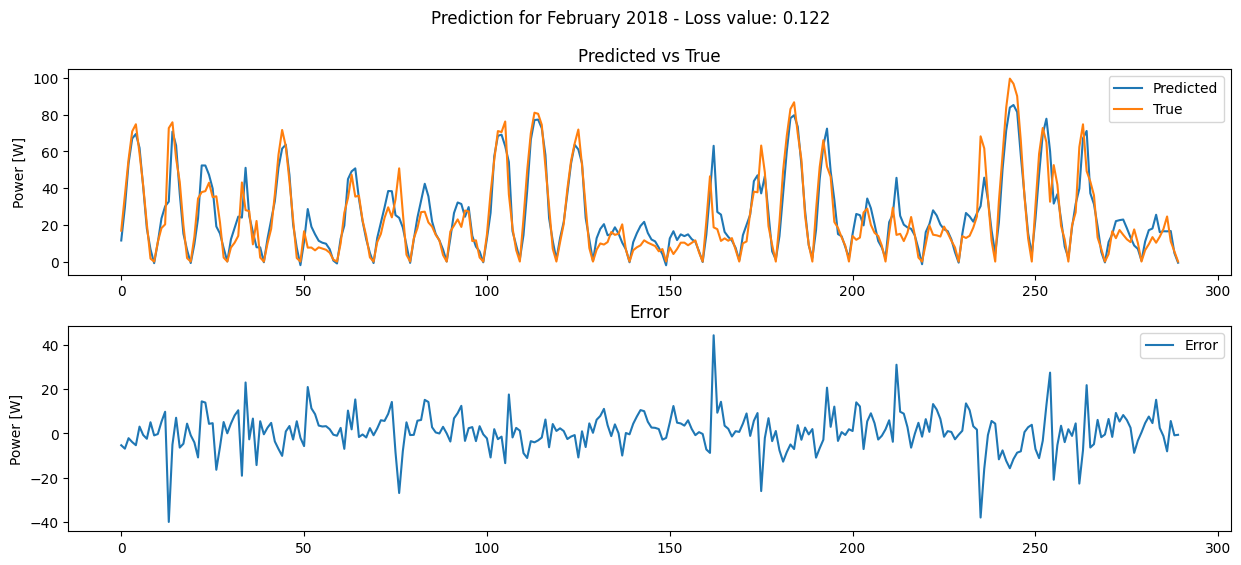

In [20]:
year = 2018
month = 2

plt.figure(figsize=(15, 6))
plt.suptitle(f'Prediction for {months_name[month]} {year} - Loss value: {df[(df["current_year"] == year) & (df["current_month"] == month)]["test_loss"].values[0]:.3f}')
plt.subplots_adjust(hspace=0.25)
plt.subplot(2, 1, 1)
plt.plot(df[(df['current_year'] == year) & (df['current_month'] == month)]['y_pred'].values[0], label='Predicted')
plt.plot(df[(df['current_year'] == year) & (df['current_month'] == month)]['y_test'].values[0], label='True')
plt.ylabel('Power [W]')
plt.title('Predicted vs True')
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.plot(df[(df['current_year'] == year) & (df['current_month'] == month)]['y_pred'].values[0] - df[(df['current_year'] == year) & (df['current_month'] == month)]['y_test'].values[0], label='Error')
plt.ylabel('Power [W]')
plt.title('Error')
plt.legend()
plt.show()